# Multi-Agent System Performance Analysis

This notebook analyzes the performance of a multi-agent vehicle routing system using metrics for:
- **Collaboration**: Communication latency and response times
- **Tool Utilization**: Success rates and utilization
- **Task Completion**: Accuracy and execution metrics
- **System Performance**: Throughput and efficiency
- **Ethical Metrics**: Fairness in task distribution

## 1. Data Loading and Preprocessing

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings


In [2]:
# Load all JSON files
def load_json(filename):
    DATA_DIR = Path('.')
    with open(DATA_DIR / filename, 'r') as f:
        return json.load(f)

# Load manager data

manager_allocations = load_json('manager_allocations.json')
manager_destination_metrics = load_json('manager_destination_metrics.json')
manager_execution_times = load_json('manager_execution_times.json')
manager_response_times = load_json('manager_response_times.json')
manager_summary = load_json('manager_summary.json')

# Load vehicle data
vehicles = {}
for i in range(1, 4):
    vehicles[i] = {
        'journeys': load_json(f'vehicle{i}_journeys.json'),
        'raw_history': load_json(f'vehicle{i}_raw_history.json'),
        'summary': load_json(f'vehicle{i}_summary.json')
    }

print("Data loaded successfully!")
print(f"Total tasks: {manager_summary['completed_tasks']}")
print(f"Number of vehicles: {manager_summary['vehicle_count']}")
print(f"Number of destinations: {manager_summary['destination_count']}")

Data loaded successfully!
Total tasks: 30
Number of vehicles: 3
Number of destinations: 8


In [3]:
# Convert to DataFrames for easier analysis
df_allocations = pd.DataFrame(manager_allocations)
df_execution = pd.DataFrame(manager_execution_times)
df_responses = pd.DataFrame(manager_response_times)

# Convert timestamps to datetime
df_execution['completion_datetime'] = pd.to_datetime(df_execution['completion_timestamp'], unit='s')
df_responses['datetime'] = pd.to_datetime(df_responses['timestamp'], unit='s')

print("\nDataFrames created:")
print(f"Allocations: {len(df_allocations)} rows")
print(f"Executions: {len(df_execution)} rows")
print(f"Responses: {len(df_responses)} rows")


DataFrames created:
Allocations: 30 rows
Executions: 30 rows
Responses: 90 rows


## 1. Comprehensive Performance Summary

In [4]:
# Create DataFrames
df_execution = pd.DataFrame(manager_execution_times)
df_responses = pd.DataFrame(manager_response_times)
if manager_allocations:
    df_allocations = pd.DataFrame(manager_allocations)
else:
    df_allocations = pd.DataFrame()

# Convert timestamps
df_execution['completion_datetime'] = pd.to_datetime(df_execution['completion_timestamp'], unit='s')
df_responses['datetime'] = pd.to_datetime(df_responses['timestamp'], unit='s')

# Journey data
journey_data = []
for vid, vdata in vehicles.items():
    for journey in vdata['journeys']:
        journey_data.append({
            'vehicle_id': vid,
            'journey_id': journey['journey_id'],
            'start_node': journey['start_node'],
            'end_node': journey['end_node'],
            'duration': journey['duration'],
            'distance': journey['distance_traveled'],
            'path_efficiency': journey['path_efficiency'],
            'carbon': journey['carbon_emitted'],
            'cost': journey['cost_incurred'],
            'velocity': journey['average_velocity'],
            'waypoint_count': journey['waypoint_count'],
            'completed': journey['completed']
        })

df_journeys = pd.DataFrame(journey_data)

print("\nDataFrames created:")
print(f"  Execution times: {len(df_execution)} tasks")
print(f"  Response times: {len(df_responses)} responses")
print(f"  Journeys: {len(df_journeys)} movements")
print(f"  Allocations: {len(df_allocations)} records")


DataFrames created:
  Execution times: 30 tasks
  Response times: 90 responses
  Journeys: 38 movements
  Allocations: 30 records


In [5]:
# Calculate comprehensive metrics
print("\n" + "="*80)
print("MULTI-AGENT SYSTEM PERFORMANCE SUMMARY REPORT")
print("="*80)

print("\nSYSTEM OVERVIEW")
print("-"*80)
print(f"Total Agents (Vehicles):              {manager_summary['vehicle_count']}")
print(f"Total Destinations:                   {manager_summary['destination_count']}")
print(f"Tasks Completed:                      {manager_summary['completed_tasks']}")
print(f"Tasks Rejected:                       {manager_summary['rejected_tasks']}")
print(f"Success Rate:                         {(manager_summary['completed_tasks']/(manager_summary['completed_tasks']+manager_summary['rejected_tasks'])*100) if (manager_summary['completed_tasks']+manager_summary['rejected_tasks']) > 0 else 100:.1f}%")

print("\nTASK vs JOURNEY BREAKDOWN")
print("-"*80)
tasks_requiring_movement = len([t for t in manager_execution_times if not t['was_already_at_destination']])
tasks_no_movement = len([t for t in manager_execution_times if t['was_already_at_destination']])
print(f"Tasks Requiring Movement:             {tasks_requiring_movement} ({tasks_requiring_movement/manager_summary['completed_tasks']*100:.1f}%)")
print(f"Tasks Already at Destination:         {tasks_no_movement} ({tasks_no_movement/manager_summary['completed_tasks']*100:.1f}%)")
print(f"Total Journeys Executed:              {len(df_journeys)}")
print(f"Average Waypoints per Journey:        {df_journeys['waypoint_count'].mean():.2f}")

print("\nCOLLABORATION METRICS")
print("-"*80)
avg_response = df_responses['response_time'].mean()
std_response = df_responses['response_time'].std()
print(f"Average Response Time:                {avg_response:.2f} ms")
print(f"Response Time Std Dev:                {std_response:.2f} ms")
print(f"Min Response Time:                    {df_responses['response_time'].min():.2f} ms")
print(f"Max Response Time:                    {df_responses['response_time'].max():.2f} ms")

if 'message_statistics' in manager_summary:
    msg_stats = manager_summary['message_statistics']
    total_messages = msg_stats.get('cfp_sent', 0) + msg_stats.get('proposals_received', 0) + msg_stats.get('assignments_sent', 0) + msg_stats.get('acceptances_received', 0) + msg_stats.get('completions_received', 0)
    print(f"Total Messages Exchanged:             {total_messages}")
    print(f"CFPs Sent:                            {msg_stats.get('cfp_sent', 0)}")
    print(f"Proposals Received:                   {msg_stats.get('proposals_received', 0)}")
    print(f"Assignments Sent:                     {msg_stats.get('assignments_sent', 0)}")
    print(f"Acceptances Received:                 {msg_stats.get('acceptances_received', 0)}")
    print(f"Completions Received:                 {msg_stats.get('completions_received', 0)}")

print("\nSYSTEM PERFORMANCE METRICS")
print("-"*80)
# Calculate from vehicle summaries
total_distance = sum(v['summary']['travel_metrics']['total_distance'] for v in vehicles.values())
total_carbon = sum(v['summary']['travel_metrics']['total_carbon_emissions'] for v in vehicles.values())
total_cost = sum(v['summary']['travel_metrics']['total_cost'] for v in vehicles.values())
total_travel_time = sum(v['summary']['travel_metrics']['total_travel_time'] for v in vehicles.values())
avg_system_velocity = np.mean([v['summary']['travel_metrics']['average_velocity'] for v in vehicles.values()])

# Get runtime from timestamps
if len(df_execution) > 0:
    start_time = df_execution['completion_timestamp'].min() - df_execution.iloc[0]['actual_time']
    end_time = df_execution['completion_timestamp'].max()
    total_runtime = end_time - start_time
    throughput = (manager_summary['completed_tasks'] / total_runtime) * 3600
    
    print(f"Total Runtime:                        {total_runtime:.1f} seconds ({total_runtime/60:.1f} minutes)")
    print(f"Throughput:                           {throughput:.2f} tasks/hour")

print(f"Total Distance Traveled:              {total_distance:.2f} units")
print(f"Total Carbon Emissions:               {total_carbon:.2f} kg")
print(f"Total Cost:                           {total_cost:.2f} units")
print(f"Total Travel Time:                    {total_travel_time:.2f} seconds")
print(f"Average System Velocity:              {avg_system_velocity:.2f} units/s")
print(f"Average Path Efficiency:              {df_journeys['path_efficiency'].mean():.2f}%")
print(f"Distance per Task:                    {(total_distance / manager_summary['completed_tasks']):.2f} units")
print(f"Carbon per Task:                      {(total_carbon / manager_summary['completed_tasks']):.2f} kg")
print(f"Cost per Task:                        {(total_cost / manager_summary['completed_tasks']):.2f} units")

print("\nFAIRNESS METRICS")
print("-"*80)
if 'fairness_metrics' in manager_summary:
    fair = manager_summary['fairness_metrics']
    avg_gini = fair.get('average_gini', 0)
    print(f"Average Gini Coefficient:             {avg_gini:.4f}")
    print(f"Final Gini Coefficient:               {fair['gini_coefficients'][-1]:.4f}")
    print(f"Initial Gini Coefficient:             {fair['gini_coefficients'][0]:.4f}")
    print(f"Gini Improvement:                     {(fair['gini_coefficients'][0] - fair['gini_coefficients'][-1]):.4f}")
    
    if avg_gini < 0.3:
        assessment = "Excellent (High Fairness)"
    elif avg_gini < 0.5:
        assessment = "Good (Moderate Fairness)"
    else:
        assessment = "Needs Improvement (Low Fairness)"
    print(f"Fairness Assessment:                  {assessment}")

print("\nPER-VEHICLE SUMMARY")
print("-"*80)
for vid in sorted(vehicles.keys()):
    vdata = vehicles[vid]
    summary = vdata['summary']
    manager_tasks = len([t for t in manager_execution_times if t['vehicle_id'] == vid])
    tasks_moved = len([t for t in manager_execution_times if t['vehicle_id'] == vid and not t['was_already_at_destination']])
    tasks_no_move = len([t for t in manager_execution_times if t['vehicle_id'] == vid and t['was_already_at_destination']])
    
    print(f"\nVehicle {vid}:")
    print(f"  Tasks Completed:                    {manager_tasks} total")
    print(f"    ├─ Required movement:             {tasks_moved}")
    print(f"    └─ Already at destination:        {tasks_no_move}")
    print(f"  Journeys Executed:                  {summary['journey_metrics']['total_journeys']}")
    print(f"  Total Distance:                     {summary['travel_metrics']['total_distance']:.2f} units")
    print(f"  Average Velocity:                   {summary['travel_metrics']['average_velocity']:.2f} units/s")
    print(f"  Carbon Emissions:                   {summary['travel_metrics']['total_carbon_emissions']:.2f} kg")
    print(f"  Total Cost:                         {summary['travel_metrics']['total_cost']:.2f} units")
    print(f"  Avg Journey Distance:               {summary['journey_metrics']['average_journey_distance']:.2f} units")
    print(f"  Avg Journey Efficiency:             {summary['journey_metrics']['average_journey_efficiency']:.2f}%")
    print(f"  Unique Nodes Visited:               {summary['journey_metrics']['unique_nodes_count']}")
    print(f"  Unique Edges Used:                  {summary['journey_metrics']['unique_edges_count']}")

print("\n" + "="*80)


MULTI-AGENT SYSTEM PERFORMANCE SUMMARY REPORT

SYSTEM OVERVIEW
--------------------------------------------------------------------------------
Total Agents (Vehicles):              3
Total Destinations:                   8
Tasks Completed:                      30
Tasks Rejected:                       0
Success Rate:                         100.0%

TASK vs JOURNEY BREAKDOWN
--------------------------------------------------------------------------------
Tasks Requiring Movement:             23 (76.7%)
Tasks Already at Destination:         7 (23.3%)
Total Journeys Executed:              38
Average Waypoints per Journey:        2.92

COLLABORATION METRICS
--------------------------------------------------------------------------------
Average Response Time:                1.22 ms
Response Time Std Dev:                0.26 ms
Min Response Time:                    0.84 ms
Max Response Time:                    2.33 ms
Total Messages Exchanged:             210
CFPs Sent:                    

## 2. Graphs

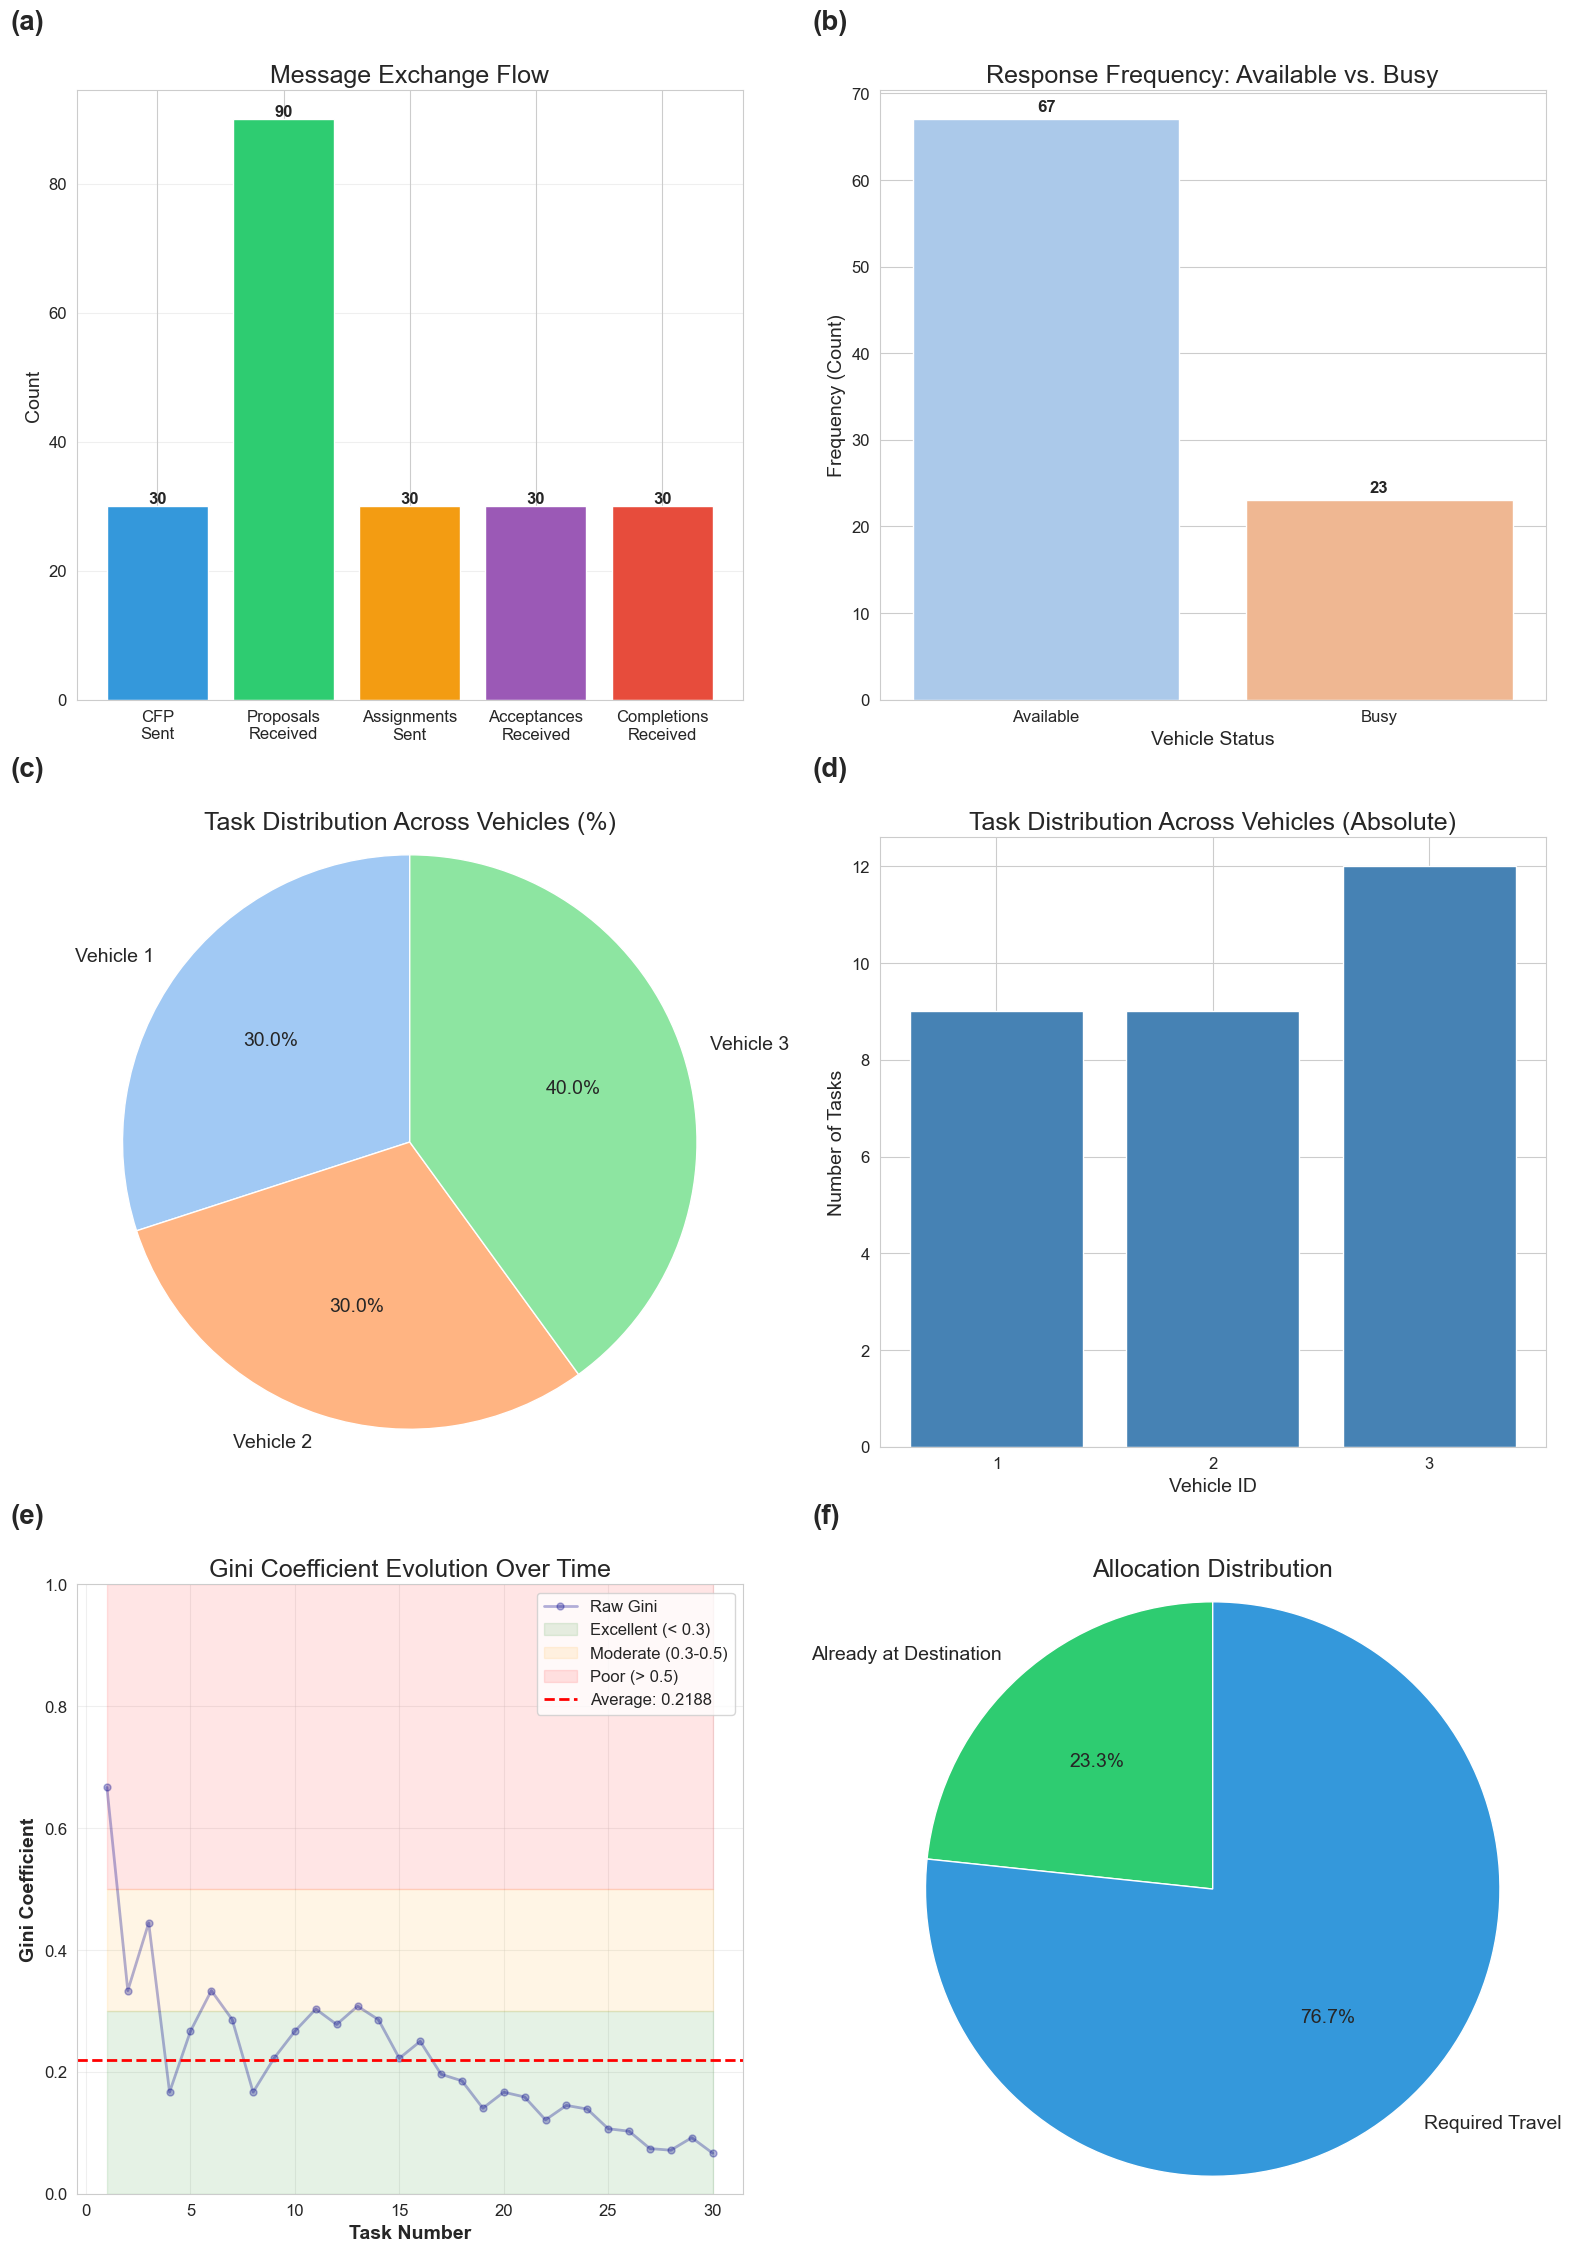

In [16]:
# --- Setup and Data Loading ---
import warnings
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# --- Font Size Configuration ---
TITLE_FONT_SIZE = 18
AXIS_LABEL_FONT_SIZE = 14
TICK_LABEL_FONT_SIZE = 12
LEGEND_FONT_SIZE = 12
SUBLABEL_FONT_SIZE = 20  # For (a), (b), etc.
SUPTITLE_FONT_SIZE = 24

# Update rcParams for tick labels
plt.rcParams['xtick.labelsize'] = TICK_LABEL_FONT_SIZE
plt.rcParams['ytick.labelsize'] = TICK_LABEL_FONT_SIZE

# Define data directory (assuming data files are in the same directory)
DATA_DIR = Path('.')

# Load all JSON files
def load_json(filename):
    try:
        with open(DATA_DIR / filename, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"Warning: {filename} not found. Plotting may fail.")
        return {}
    except json.JSONDecodeError:
        print(f"Warning: Error decoding {filename}. Plotting may fail.")
        return {}

# Load manager data
manager_allocations = load_json('manager_allocations.json')
manager_summary = load_json('manager_summary.json')
manager_response_times = load_json('manager_response_times.json')
manager_execution_times = load_json('manager_execution_times.json')

# Convert to DataFrames
df_allocations = pd.DataFrame(manager_allocations)
df_execution = pd.DataFrame(manager_execution_times)
df_responses = pd.DataFrame(manager_response_times)

# --- Helper Function (from notebook cell 16) ---
def gini_coefficient(values):
    """Calculate Gini coefficient for a distribution"""
    if not isinstance(values, np.ndarray):
        values = np.array(values)
    if values is None or len(values) == 0 or values.sum() == 0:
        return 0  # Avoid division by zero
    sorted_values = np.sort(values)
    n = len(values)
    cumsum = np.cumsum(sorted_values)
    return (2 * np.sum((np.arange(1, n + 1)) * sorted_values)) / (n * cumsum[-1]) - (n + 1) / n

# --- Data Preprocessing for Response Times ---
if not df_responses.empty and not df_allocations.empty:
    if 'response_time' in df_responses.columns and 'task_id' in df_responses.columns and 'task_id' in df_allocations.columns:
        df_responses['response_time_ms'] = df_responses['response_time'] * 1000
        # Create a map of task_id to its busy_vehicles list
        busy_map = df_allocations.set_index('task_id')['busy_vehicles'].to_dict()
        
        # Map this to df_responses
        df_responses['busy_list'] = df_responses['task_id'].map(busy_map)
        
        # Check if the vehicle was busy for that task
        df_responses['is_busy'] = df_responses.apply(
            lambda row: row['vehicle_id'] in row['busy_list'] if isinstance(row['busy_list'], list) else False,
            axis=1
        )
    else:
        print("Warning: 'response_time' or 'task_id' missing from dataframes. Response plots may fail.")
elif df_responses.empty:
     print("Warning: manager_response_times.json not found. Response plots will be empty.")
elif df_allocations.empty:
    print("Warning: manager_allocations.json not found. 'Busy' status for responses cannot be determined.")
    if 'response_time' in df_responses.columns:
         df_responses['response_time_ms'] = df_responses['response_time'] * 1000
    df_responses['is_busy'] = False # Assume all are available

# --- Create 3x2 Subplot Grid ---
fig, axes = plt.subplots(3, 2, figsize=(16, 24)) 

# --- 1. (a) Message exchange flow (bar chart) [0, 0] ---
# MOVED from (e)
ax = axes[0, 0]
ax.text(-0.1, 1.1, '(a)', transform=ax.transAxes, fontsize=SUBLABEL_FONT_SIZE, fontweight='bold')
if 'message_statistics' in manager_summary:
    msg_stats = manager_summary['message_statistics']
    stages = ['CFP\nSent', 'Proposals\nReceived', 'Assignments\nSent',
              'Acceptances\nReceived', 'Completions\nReceived']
    counts = [msg_stats.get('cfp_sent', 0), msg_stats.get('proposals_received', 0),
              msg_stats.get('assignments_sent', 0), msg_stats.get('acceptances_received', 0),
              msg_stats.get('completions_received', 0)]
    
    colors = ['#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#e74c3c']
    bars = ax.bar(stages, counts, color=colors)
    ax.set_ylabel('Count', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.set_title('Message Exchange Flow', fontsize=TITLE_FONT_SIZE)
    ax.grid(axis='y', alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', 
                fontweight='bold', fontsize=TICK_LABEL_FONT_SIZE)
else:
    ax.text(0.5, 0.5, 'manager_summary.json (message_statistics) not found', horizontalalignment='center')
    ax.set_title('Message Exchange Flow', fontsize=TITLE_FONT_SIZE)

# --- 2. (b) Available vs. Busy Response (Frequency) [0, 1] ---
# MOVED from (f)
ax = axes[0, 1]
ax.text(-0.1, 1.1, '(b)', transform=ax.transAxes, fontsize=SUBLABEL_FONT_SIZE, fontweight='bold')
if not df_responses.empty and 'is_busy' in df_responses.columns:
    # Use sns.countplot to show frequency
    sns.countplot(x='is_busy', data=df_responses, ax=ax, palette='pastel', order=[False, True]) 
    ax.set_xlabel('Vehicle Status', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.set_ylabel('Frequency (Count)', fontsize=AXIS_LABEL_FONT_SIZE) # Changed Y-label
    ax.set_title('Response Frequency: Available vs. Busy', fontsize=TITLE_FONT_SIZE) # Changed Title
    ax.set_xticklabels(['Available', 'Busy'], fontsize=TICK_LABEL_FONT_SIZE)
    
    # Add count labels on top of bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 9), 
                    textcoords='offset points',
                    fontweight='bold',
                    fontsize=TICK_LABEL_FONT_SIZE)
else:
    ax.text(0.5, 0.5, 'Response or allocation data missing', horizontalalignment='center')
    ax.set_title('Response Frequency: Available vs. Busy', fontsize=TITLE_FONT_SIZE) # Changed Title


# --- 3. (c) Average task distribution (percentage pie chart) [1, 0] ---
# MOVED from (a)
ax = axes[1, 0]
ax.text(-0.1, 1.1, '(c)', transform=ax.transAxes, fontsize=SUBLABEL_FONT_SIZE, fontweight='bold')
if not df_execution.empty:
    task_counts = df_execution['vehicle_id'].value_counts().sort_index()
    ax.pie(task_counts.values,
           labels=[f"Vehicle {i}" for i in task_counts.index],
           autopct='%1.1f%%', startangle=90,
           colors=sns.color_palette('pastel'),
           textprops={'fontsize': AXIS_LABEL_FONT_SIZE})
    ax.set_title('Task Distribution Across Vehicles (%)', fontsize=TITLE_FONT_SIZE)
else:
    ax.text(0.5, 0.5, 'manager_execution_times.json not found', horizontalalignment='center')
    ax.set_title('Task Distribution Across Vehicles (%)', fontsize=TITLE_FONT_SIZE)
ax.axis('equal') # Ensure pie is circular

# --- 4. (d) Average task distribution (absolute value bar chart) [1, 1] ---
# MOVED from (b)
ax = axes[1, 1]
ax.text(-0.1, 1.1, '(d)', transform=ax.transAxes, fontsize=SUBLABEL_FONT_SIZE, fontweight='bold')
if not df_execution.empty:
    vehicle_tasks = df_execution.groupby('vehicle_id').size()
    ax.bar(vehicle_tasks.index.map(str), vehicle_tasks.values, color='steelblue')
    ax.set_xlabel('Vehicle ID', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.set_ylabel('Number of Tasks', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.set_title('Task Distribution Across Vehicles (Absolute)', fontsize=TITLE_FONT_SIZE)
    ax.set_xticks(vehicle_tasks.index.map(str))
else:
    ax.text(0.5, 0.5, 'manager_execution_times.json not found', horizontalalignment='center')
    ax.set_title('Task Distribution Across Vehicles (Absolute)', fontsize=TITLE_FONT_SIZE)

# --- 5. (e) Gini Coefficient variation with task number [2, 0] ---
# MOVED from (c)
ax = axes[2, 0]
ax.text(-0.1, 1.1, '(e)', transform=ax.transAxes, fontsize=SUBLABEL_FONT_SIZE, fontweight='bold')
if 'fairness_metrics' in manager_summary:
    gini_history = manager_summary['fairness_metrics'].get('gini_coefficients', [])
    avg_gini = manager_summary['fairness_metrics'].get('average_gini', 0)
    
    if gini_history:
        task_numbers = np.arange(1, len(gini_history) + 1)
        
        # Plot raw data and moving average
        window = min(5, len(gini_history))
        ax.plot(task_numbers, gini_history, marker='o', linewidth=2, markersize=5, color='darkblue', alpha=0.3, label='Raw Gini')

        # Add colored background regions
        ax.fill_between(task_numbers, 0, 0.3, alpha=0.1, color='green', label='Excellent (< 0.3)')
        ax.fill_between(task_numbers, 0.3, 0.5, alpha=0.1, color='orange', label='Moderate (0.3-0.5)')
        ax.fill_between(task_numbers, 0.5, 1, alpha=0.1, color='red', label='Poor (> 0.5)')
        
        ax.axhline(avg_gini, color='red', linestyle='--', linewidth=2,
                   label=f"Average: {avg_gini:.4f}")
        
        ax.set_xlabel('Task Number', fontsize=AXIS_LABEL_FONT_SIZE, fontweight='bold')
        ax.set_ylabel('Gini Coefficient', fontsize=AXIS_LABEL_FONT_SIZE, fontweight='bold')
        ax.set_title('Gini Coefficient Evolution Over Time', fontsize=TITLE_FONT_SIZE)
        ax.set_ylim(0, 1) # Set y-axis from 0 to 1
        ax.legend(loc='upper right', fontsize=LEGEND_FONT_SIZE)
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No Gini history data found', horizontalalignment='center')
        ax.set_title('Gini Coefficient Evolution Over Time', fontsize=TITLE_FONT_SIZE)
else:
    ax.text(0.5, 0.5, 'manager_summary.json (fairness_metrics) not found', horizontalalignment='center')
    ax.set_title('Gini Coefficient Evolution Over Time', fontsize=TITLE_FONT_SIZE)

# --- 6. (f) Allocation efficiency (pie chart) [2, 1] ---
# MOVED from (d)
ax = axes[2, 1]
ax.text(-0.1, 1.1, '(f)', transform=ax.transAxes, fontsize=SUBLABEL_FONT_SIZE, fontweight='bold')
if not df_allocations.empty:
    dest_status = df_allocations['winner_already_at_destination'].value_counts()
    ax.pie([dest_status.get(True, 0), dest_status.get(False, 0)],
           labels=['Already at Destination', 'Required Travel'],
           autopct='%1.1f%%', colors=['#2ecc71', '#3498db'], startangle=90,
           textprops={'fontsize': AXIS_LABEL_FONT_SIZE})
    ax.set_title('Allocation Distribution', fontsize=TITLE_FONT_SIZE)
else:
    ax.text(0.5, 0.5, 'manager_allocations.json not found', horizontalalignment='center')
    ax.set_title('Allocation Efficiency (Winner at Destination)', fontsize=TITLE_FONT_SIZE)
ax.axis('equal') # Ensure pie is circular


# --- Display Plot 1 ---
plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjusted rect for suptitle
plt.show()

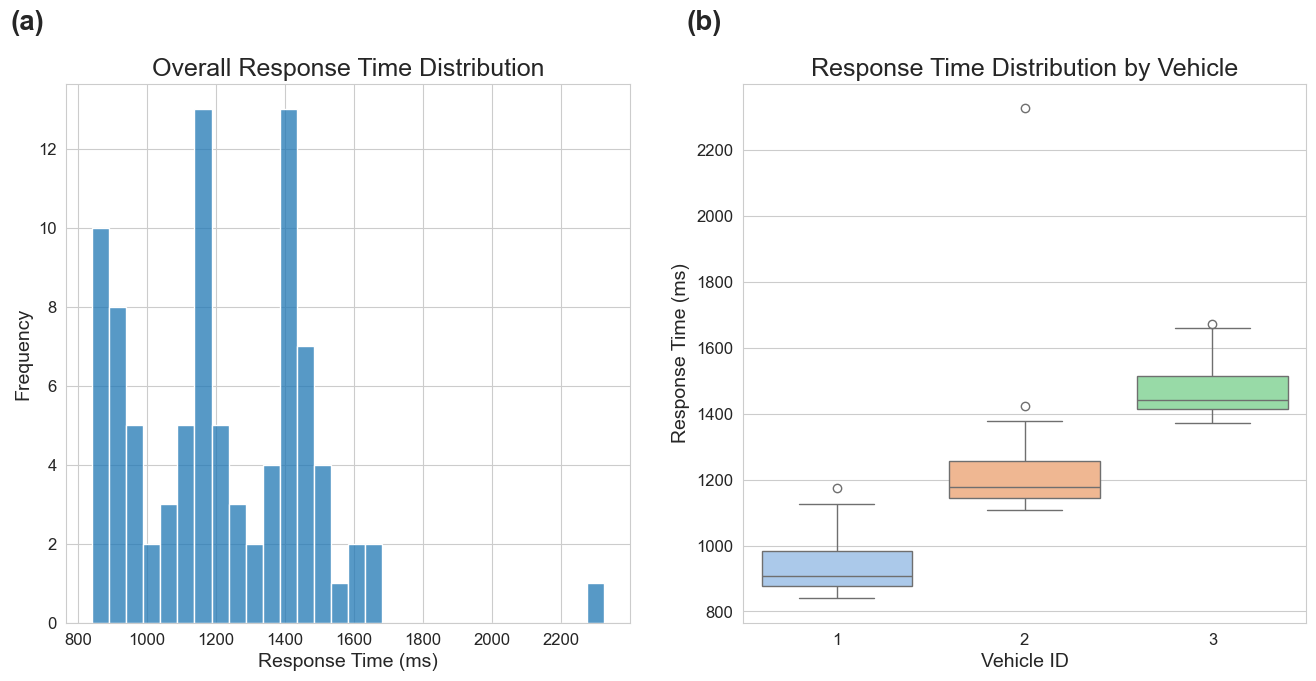

In [13]:
# --- Cell 2: Response Time Details ---
# This cell creates a new figure for the remaining plots (g and h)

# Create a new 1x2 Subplot Grid
fig2, axes2 = plt.subplots(1, 2, figsize=(16, 7))


# --- 7. (g) Distribution of Agent Response Time (histogram) [0] ---
ax = axes2[0] # Changed from axes[3, 0]
ax.text(-0.1, 1.1, '(a)', transform=ax.transAxes, fontsize=SUBLABEL_FONT_SIZE, fontweight='bold')
if not df_responses.empty and 'response_time_ms' in df_responses.columns:
    sns.histplot(df_responses['response_time_ms'], bins=30, ax=ax) # Added kde for clarity
    ax.set_xlabel('Response Time (ms)', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.set_ylabel('Frequency', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.set_title('Overall Response Time Distribution', fontsize=TITLE_FONT_SIZE)
else:
    ax.text(0.5, 0.5, 'manager_response_times.json not found', horizontalalignment='center')
    ax.set_title('Overall Response Time Distribution', fontsize=TITLE_FONT_SIZE)

# --- 8. (h) Response Time Distribution by Vehicle (boxplot) [1] ---
ax = axes2[1] # Changed from axes[3, 1]
ax.text(-0.1, 1.1, '(b)', transform=ax.transAxes, fontsize=SUBLABEL_FONT_SIZE, fontweight='bold')
if not df_responses.empty and 'response_time_ms' in df_responses.columns:
    sns.boxplot(x='vehicle_id', y='response_time_ms', data=df_responses, ax=ax, palette='pastel')
    ax.set_xlabel('Vehicle ID', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.set_ylabel('Response Time (ms)', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.set_title('Response Time Distribution by Vehicle', fontsize=TITLE_FONT_SIZE)
else:
    ax.text(0.5, 0.5, 'manager_response_times.json not found', horizontalalignment='center')
    ax.set_title('Response Time Distribution by Vehicle', fontsize=TITLE_FONT_SIZE)


plt.show()